# Modelagem Sistema Fotovoltaico

### Importando bibliotecas

In [ ]:
import pandas as pd
import numpy as np
import gspread

from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn import preprocessing
from sklearn.linear_model import LinearRegression

In [ ]:
# Authenticate and create the PyDrive client.
from google.colab import auth
auth.authenticate_user()
from google.auth import default

In [ ]:
creds, _ = default()
gc = gspread.authorize(creds)

### Leitura e Tratamento dos Dados

In [ ]:
worksheet = gc.open('Dados diários de produção de energia').sheet1
rows = worksheet.get_all_values()
planilha = pd.DataFrame.from_records(rows)

In [ ]:
planilha.columns = planilha.iloc[0]
planilha = planilha[1:]

In [ ]:
planilha.head(5)

,Data,Produção (kWh),Temperatura média (ºC),Precipitação de chuva (mm),Incidencia UV
1,01/03/2023,"22,6",23,"2,9",14
2,02/03/2023,"23,1","24,2","6,3",14
3,03/03/2023,"17,2","24,4","1,7",13
4,04/03/2023,"26,2","24,6","13,6",14
5,05/03/2023,"20,3","24,4","1,8",14


In [ ]:
planilha.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 299 entries, 1 to 299
Data columns (total 5 columns):
 #   Column                      Non-Null Count  Dtype 
---  ------                      --------------  ----- 
 0   Data                        299 non-null    object
 1   Produção (kWh)              299 non-null    object
 2   Temperatura média (ºC)      299 non-null    object
 3   Precipitação de chuva (mm)  299 non-null    object
 4   Incidencia UV               299 non-null    object
dtypes: object(5)
memory usage: 11.8+ KB


In [ ]:
planilha.shape

(299, 5)

In [ ]:
planilha = planilha.apply(lambda x: x.str.replace(',','.'))

In [ ]:
planilha = planilha.apply(lambda x: x.str.replace('/','-'))

In [ ]:
planilha['Data'] = pd.to_datetime(planilha['Data'], format='%d-%m-%Y')

In [ ]:
planilha[['Temperatura média (ºC)',
          'Precipitação de chuva (mm)',
          'Incidencia UV']] = planilha[['Temperatura média (ºC)',
                                        'Precipitação de chuva (mm)',
                                        'Incidencia UV']].astype('float')

In [ ]:
planilha = planilha.set_index('Data')

In [ ]:
planilha.head(5)

,Produção (kWh),Temperatura média (ºC),Precipitação de chuva (mm),Incidencia UV
Data,,,,
2023-03-01,22.6,23.0,2.9,14.0
2023-03-02,23.1,24.2,6.3,14.0
2023-03-03,17.2,24.4,1.7,13.0
2023-03-04,26.2,24.6,13.6,14.0
2023-03-05,20.3,24.4,1.8,14.0


### Modelagem do Sistema

**Modelo de Regressão Linear Múltipla**

A regressão linear múltipla é uma técnica multivariada cuja finalidade principal é obter uma relação matemática entre uma das variáveis estudadas (variável dependente ou resposta) e o restante das variáveis que descrevem o sistema (variáveis independentes ou explicativas).

Sua principal aplicação, após encontrar a relação matemática, é produzir valores para a variável dependente quando se têm as variáveis independentes
(cálculo dos valores preditos).

A inclusão de novas variáveis na equação de ajuste pode ser feita para aumentar o grau de correlação entre os dados teóricos e reais. Tal modelo apresenta a seguinte equação:

$$Y = \beta_{0} + \beta_{1}X_{1} + ... + \beta_{p}X_{p} + e$$

sendo $X_{p}$ a p-ésima variável observada, $\beta_{p}$ o coeficiente associado à p-ésima variável e

$$e = Y - Ŷ$$

o erro que apresenta distribuição normal com média zero e variância $\sigma^{2}$.

O resultado do modelo é um único valor que representa uma combinação do conjunto inteiro de variáveis que melhor atinge o objetivo da análise multivariada específica.

In [ ]:
X = planilha.drop('Produção (kWh)', axis=1)
y = planilha['Produção (kWh)']

**Dados de Treino:**
> Período de 01-03-2023 até 08-11-2023



In [ ]:
X_train = X.loc['2023-02-03':'2023-11-08']
y_train = y.loc['2023-02-03':'2023-11-08'].astype('float')

**Dados de Validação:**
> Período de 09-11-2023 até 09-12-2023

In [ ]:
X_val = X.loc['2023-11-09':'2023-12-09']
y_val = y.loc['2023-11-09':'2023-12-09'].astype('float')

**Dados para previsão dos próximos 15 dias**

>Período de 10-12-2023 até 24-12-2023

**Distribuição das variáveis e como cada uma

In [ ]:
X_pred = X.loc['2023-11-10':]

In [ ]:
df = planilha.loc[:'2023-12-09'].astype('float')

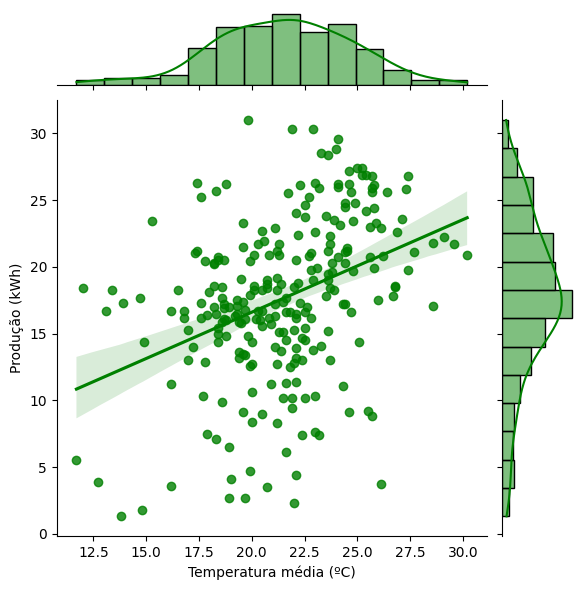

In [ ]:
sns.jointplot(x=X_train['Temperatura média (ºC)'], y=y_train, kind='reg',color='green')
plt.show()

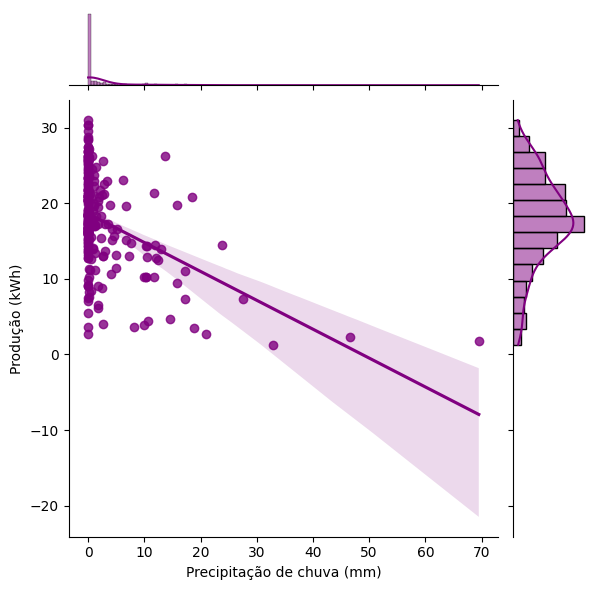

In [ ]:
sns.jointplot(x=X_train['Precipitação de chuva (mm)'], y=y_train, kind='reg',color='purple')
plt.show()

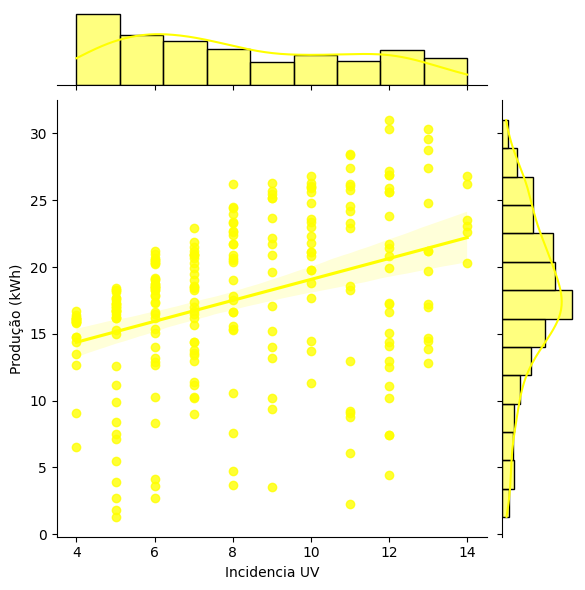

In [ ]:
sns.jointplot(x=X_train['Incidencia UV'], y=y_train, kind='reg',color='yellow')
plt.show()

**Correlação entre as variáveis**

Em estatística descritiva, o **coeficiente de correlação de Pearson**, mede o grau da correlação (e a direcção dessa correlação - se positiva ou negativa) entre duas variáveis de escala métrica. Este coeficiente, normalmente representado por ρ assume apenas valores entre -1 e 1.



*   ρ = 1  Significa uma correlação perfeita positiva entre as duas variáveis.
*   ρ = -1 Significa uma correlação negativa perfeita entre as duas variáveis - Isto é, se uma aumenta, a outra sempre diminui.
* ρ = 0 Significa que as duas variáveis não dependem linearmente uma da outra. No entanto, pode existir uma dependência não linear.





In [ ]:
pd.DataFrame(df.corr())

,Produção (kWh),Temperatura média (ºC),Precipitação de chuva (mm),Incidencia UV
0,,,,
Produção (kWh),1.000000,0.373435,-0.451522,0.323323
Temperatura média (ºC),0.373435,1.000000,-0.032331,0.674493
Precipitação de chuva (mm),-0.451522,-0.032331,1.000000,0.200271
Incidencia UV,0.323323,0.674493,0.200271,1.000000


**Treinando o Modelo**

In [ ]:
model = LinearRegression()
model.fit(X_train, y_train)

LinearRegression()

In [ ]:
y_pred = model.predict(X_val)

In [ ]:
prediction_df = X_val.copy()

In [ ]:
pd.options.mode.chained_assignment = None

In [ ]:
prediction_df.loc[:,'Produção Prevista (kWh)'] = np.round(y_pred,1)

**Erro Médio Absoluto - MAE**

O erro médio absoluto, MAE (da sigla em inglês Mean Absolute Error), é calculado a partir da média dos erros absolutos, ou seja, utilizamos o módulo de cada erro para evitar a subestimação, isso porque, o valor é menos afetado por pontos especialmente extremos (outliers). Cada erro, pode ser interpretado como a diferença entre Y e Ŷ e assim, temos:


$$MAE = \frac{1}{N}\sum_{1}^{N}\left | Y_{i}-Ŷ_{i} \right|$$

**Erro Quadrático Médio - MSE**


O erro quadrático médio, MSE (da sigla em inglês Mean Squared Error), é comumente usado para verificar a acurácia de modelos e dá um maior peso aos maiores erros, já que, ao ser calculado, cada erro é elevado ao quadrado individualmente e, após isso, a média desses erros quadráticos é calculada.
Usando o mesmo conceito de erro utilizado anteriormente, temos a equação abaixo:

$$MSE = \frac{1}{N}\sum_{1}^{N}\left ( Y_{i}-Ŷ_{i} \right )^{2}$$

**Raiz Quadrada do Erro Médio - RMSE**


A raiz quadrada do erro médio, RMSE (da sigla em inglês Root Mean Squared Error) é apenas a raiz quadrada do MSE, onde o erro retorna à unidade de medida do modelo (no MSE, a unidade de medida é quadrática).

$$RMSE = \sqrt{\sum_{1}^{N}\frac{\left ( y_{i}-Ŷ_{i} \right )^{2}}{n}}$$

In [ ]:
print('Erro Absoluto Médio:', metrics.mean_absolute_error(y_val,y_pred))
print('Erro Médio Quadrado:', metrics.mean_squared_error(y_val,y_pred))
print('Raiz do Erro Médio Quadrado:', np.sqrt(metrics.mean_squared_error(y_val,y_pred)))

Erro Absoluto Médio: 3.479007913720571
Erro Médio Quadrado: 27.24873598600992
Raiz do Erro Médio Quadrado: 5.220032182468794


In [ ]:
print(model.coef_,model.intercept_)

[ 0.19093721 -0.42755894  0.81053411] 8.041468749432465


In [ ]:
x1, x2, x3 = model.coef_
intercept = model.intercept_
print('y = %.5f*x1 %.5f*x2 + %.5f*x3 + %.5f' % (x1, x2, x3, intercept))

y = 0.19094*x1 -0.42756*x2 + 0.81053*x3 + 8.04147


In [ ]:
prediction_df.head(5)

,Temperatura média (ºC),Precipitação de chuva (mm),Incidencia UV,Produção Prevista (kWh)
Data,,,,
2023-11-09,26.9,16.4,12.0,15.9
2023-11-10,26.5,0.0,12.0,22.8
2023-11-11,29.3,0.0,12.0,23.4
2023-11-12,30.6,0.0,13.0,24.4
2023-11-13,29.3,0.7,13.0,23.9


**Análise de Resíduos**

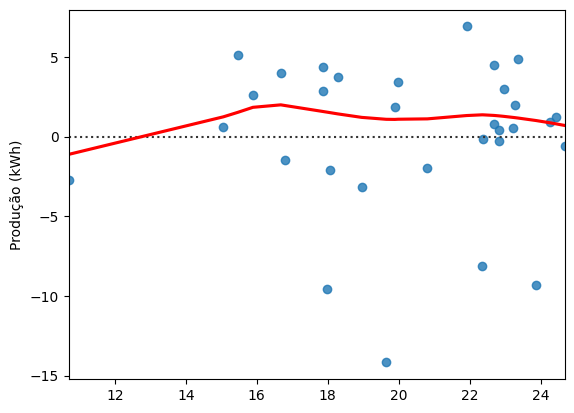

In [ ]:
sns.residplot(x=y_pred, y=y_val, lowess=True, line_kws=dict(color="r"))
plt.show()

### Calculo do Percentual de Unidades produzindo energia

Utilizaremos os dados de previsão do tempo para os próximos 14 dias (Temperatura média (ºC), Precipitação de chuva (mm)	e Incidencia UV). Dados retirados de <https://www.tempo.com/londrina-aeroporto-proxima-semana.htm>


- Os dados previstos para os próximos 14 dias são referentes a produção de energia em kWh para 1 unidade.
- A demanda de energia eletrica considerada será de 168,6 kWh/mês por unidade
- O número atual de unidades consumidoras no Paraná é de 4.190.534 unidades

In [ ]:
X_pred.head(3)

,Temperatura média (ºC),Precipitação de chuva (mm),Incidencia UV
Data,,,
2023-11-10,26.5,0.0,12.0
2023-11-11,29.3,0.0,12.0
2023-11-12,30.6,0.0,13.0


In [ ]:
y_previsto = model.predict(X_pred)

In [ ]:
X_pred['Produção Prevista (kWh)'] = np.round(y_previsto,1)

In [ ]:
demanda_mensal = 168.6
unidades = 4190534

In [ ]:
E = demanda_mensal/2*unidades

In [ ]:
print('A demanda de energia necessaria nos próximos 14 dias é de %.5f kWh'% (E))

A demanda de energia necessaria nos próximos 14 dias é de 353262016.20000 kWh


In [ ]:
Y = X_pred['Produção Prevista (kWh)'].sum()

In [ ]:
unidades_neces_produzindo = np.round(E/Y)

In [ ]:
print('Para suprir essa demanda, é necessario que %.5f unidades produzam energia nos próximos 14 dias'% (unidades_neces_produzindo))

Para suprir essa demanda, é necessario que 382691.00000 unidades produzam energia nos próximos 14 dias


In [ ]:
P = unidades_neces_produzindo*100/unidades

In [ ]:
print('Isso representa um percentual de %.5f'% (P))

Isso representa um percentual de 9.13227
